# Detecting Fake News using Graph Neural Networksin Knowledge Graphs 
This notebook will be used to valuate the classification prerformance of our model. Be sure to have trained a model using the specific fake news dataset to ensure all entities have been "observed" and assigned an embedding. 

# LIAR
## Step 1: Import triple extracted dataset

In [62]:
import pandas as pd
#load test data
LIAR = pd.read_csv(
        "./data/LIAR/test.csv",
        sep=";",
        header=0,
        engine="python",
        usecols = ['text_id', 'head', 'relation', 'tail', 'fb_head', 'fb_tail', 'label']

    )


heads = LIAR["fb_head"]
tails = LIAR["fb_tail"]
relations = LIAR["relation"]

relations = ["/" + rel for rel in relations]

print(relations[0])


LIAR.head(1)

/people/person/employment_history./business/employment_tenure/title


,text_id,head,relation,tail,label,fb_head,fb_tail
0,9524.json,Scott Walker,people/person/employment_history./business/emp...,governor,False,/m/04tzmt,/m/05pd99q


In [63]:
from os import path
import numpy as np
import torch
#construct entity encoder with original and new entity ids
entity_id = pd.read_csv('data/FB15k/entities.txt', sep='\t', header=None, names=['entity', 'id'], engine='python')
model_entities = entity_id['entity'].values
print('no. unique entities (original):', len(model_entities))

# add unseen entities from fake news dataset
dataset_entities = np.concatenate([np.array(heads), np.array(tails)])
dataset_entities =  np.unique(dataset_entities)
print('no. unique entities in dataset:', len(dataset_entities))
new_entities = np.array([ent for ent in dataset_entities if not ent in model_entities])
print('no. unseen entities in dataset:', len(new_entities))

all_entities = np.concatenate((model_entities, new_entities), axis=0)
print('no. unique entities (updated):', len(all_entities))


no. unique entities (original): 14951
no. unique entities in dataset: 155
no. unseen entities in dataset: 108
no. unique entities (updated): 15059


In [64]:
from sklearn.preprocessing import LabelEncoder

# fit encoder
le_entity = LabelEncoder()
le_entity.classes_ = np.load(path.join('fn_embeddings','le_entity_classes_LIAR.npy'), allow_pickle=True)
#load relation encoder
le_relation = LabelEncoder()
le_relation.classes_ = np.load(path.join('fn_embeddings','le_relation_classes_LIAR.npy'), allow_pickle=True)

In [65]:
test_rel = '/american_football/football_team/current_roster./sports/sports_team_roster/position'
test_rel2 = '/people/person/employment_history./business/employment_tenure/title'
print('le_relation test: ', le_relation.transform([test_rel2]))

print(le_relation.transform([relations[3]]))

le_relation test:  [1033]
[1033]


In [66]:
#create torch_geometric Data object
#edge_index = torch.tensor([le_heads, le_tails], dtype=torch.long)
#edge_attributes = torch.tensor(le_relation.transform(relations), dtype=torch.long)
#dataset = Data(x=le_entity.transform(all_entities), edge_type=edge_attributes, edge_index=edge_index)


In [67]:
le_heads = le_entity.transform(heads)
le_tails = le_entity.transform(tails)
edge_index = torch.tensor([le_heads, le_tails], dtype=torch.long)

le_relations = le_relation.transform(relations)
edge_type = torch.tensor(le_relations, dtype=torch.long)

In [68]:
# create and 'encode' lables
raw_labels = np.array(LIAR["label"])
false = 0
true = 0
for l in raw_labels:
    if l == False:
        false += 1
    else:
        true += 1
print('no. true:', true)
print('no. false:', false)
labels = torch.tensor([0 if l == False else 1 for l in raw_labels], dtype=torch.int64)
labels

no. true: 79
no. false: 122


tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0])

## Step 2: Classify using Multi-Relational GraphStar model
Use model pretrained with the entities of this specific fake news dataset.

In [69]:
# use env37test kernel
import torch
model = torch.load("output/FB15k_237_CPU_60epochs.pkl", map_location=torch.device('cpu'))

#model

In [70]:
z = model.z
z.size()

torch.Size([15167, 256])

In [71]:

pred = model.lp_score(z, edge_index, edge_type)
lp_auc, lp_ap = model.lp_test(pred, labels)

print('ap:', lp_ap, ', auc:', lp_auc)

ap: 0.40816418350539074 , auc: 0.49927370823822376


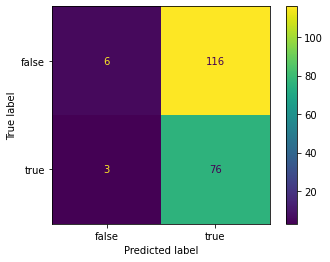

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay

pred_classes = torch.tensor([0 if p < 0 else 1 for p in pred], dtype=torch.int64)

cm = confusion_matrix(labels, pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['false', 'true']) #usikker på rekkefølgen her
disp.plot()

In [12]:
predicted_raw_labels = [False if p == 0 else True for p in pred_classes]
predicted_raw_labels
LIAR['predicted_label'] = predicted_raw_labels

LIAR[50:60]

,text_id,head,relation,tail,label,fb_head,fb_tail,predicted_label
50,2615.json,Lee Fisher,people/person/employment_history./business/emp...,Lieutenant governor,False,/m/034q8v,/m/0fkzq,True
51,592.json,United States Senate,organization/organization/headquarters./locati...,United States,False,/m/07t58,/m/09c7w0,False
52,12745.json,Barack Obama,people/person/employment_history./business/emp...,President of the United States,True,/m/02mjmr,/m/060d2,True
53,6386.json,Jon Runyan,people/person/employment_history./business/emp...,Member of Congress,False,/m/04q2pt,/m/01gkgk,True
54,8676.json,Rick Scott,people/person/employment_history./business/emp...,governor,False,/m/0btx2g,/m/05pd99q,True
55,8853.json,Barack Obama,people/person/employment_history./business/emp...,President of the United States,False,/m/02mjmr,/m/060d2,True
56,10208.json,Barack Obama,people/person/employment_history./business/emp...,President of the United States,False,/m/02mjmr,/m/060d2,True
57,11409.json,Charlie Dent,people/person/employment_history./business/emp...,Rep,False,/m/04fcm3,/m/07r8g3,True
58,12994.json,Bill Clinton,people/person/employment_history./business/emp...,Secretary,True,/m/0157m,/m/01fcnx,True
59,9891.json,Lorne Michaels,people/person/employment_history./business/emp...,Executive producer,True,/m/0p_2r,Executive producer,True


## Step 3: Dataset exploration
We suspect some issues with classification performance stem from the quality of the LIAR RDF dataset. To futher understand the limitations of our model, we will try to explore what properties of the dataset make classification hard.  

### Conflicting labels
Identical triples may have been extracted from both true and false documents, meaning they will exist in our dataset with conflicting labels:

In [73]:
# create array of triples [[h,r,t], [h,r,t], [h,r,t], ...]
triples = np.vstack((heads, relations, tails)).T
print('no. triples: ', len(triples))
triples[:1]

no. triples:  201


array([['/m/04tzmt',
        '/people/person/employment_history./business/employment_tenure/title',
        '/m/05pd99q']], dtype=object)

In [74]:
print('no. unique triples:', len(set([triple[0] + triple[1] + triple[2] for triple in triples])))

no. unique triples: 134


In [75]:
triple_dict = {}
conflicting_triples = []
for i in range(len(triples)):
    triple = tuple(triples[i])
    if triple in triple_dict:    
        if triple_dict[triple] != labels[i]:
            conflicting_triples.append(triple)
    else:
        triple_dict[triple] = labels[i]
conflicting_triples = set(conflicting_triples)

In [76]:
for triple in conflicting_triples:
    print(triple[0], triple[1], triple[2])

print('\nno. uniqe triples associated with both labels:', len(conflicting_triples))

/m/0f8t6k /people/person/employment_history./business/employment_tenure/title /m/05pd99q
/m/0271_s /people/person/employment_history./business/employment_tenure/title /m/05pd99q
/m/02mjmr /people/person/employment_history./business/employment_tenure/title /m/048zv9l
/m/0157m /people/person/employment_history./business/employment_tenure/title /m/060d2
/m/04tzmt /people/person/employment_history./business/employment_tenure/title /m/05pd99q
/m/02mjmr /people/person/employment_history./business/employment_tenure/title /m/060d2
/m/01fwm3 /organization/role/leaders./organization/leadership/person /m/07t58

no. uniqe triples associated with both labels: 7


#### option 1: removing triples 
remove all triples included in label conflict

In [77]:
cleaned_triples = []
cleaned_labels = []
for i in range(len(triples)):
    triple = triples[i]
    triple = tuple(triple)
    if triple not in conflicting_triples:
        cleaned_triples.append(triple)
        cleaned_labels.append(labels[i])
print('no. triples in cleaned dataset:', len(cleaned_triples))

cleaned_triples = np.array(cleaned_triples)
cleaned_labels = torch.tensor(cleaned_labels, dtype=torch.int64)

no. triples in cleaned dataset: 143


In [78]:
t = np.vsplit(cleaned_triples.T, 3)

cleaned_heads = t[0].flatten()
cleaned_relations = t[1].flatten()
cleaned_tails = t[2].flatten()


cleaned_le_heads = le_entity.transform(cleaned_heads)
cleaned_le_tails = le_entity.transform(cleaned_tails)
cleaned_edge_index = torch.tensor([cleaned_le_heads, cleaned_le_tails], dtype=torch.long)

cleaned_le_relations = le_relation.transform(cleaned_relations)
cleaned_edge_type = torch.tensor(cleaned_le_relations, dtype=torch.long)

In [80]:
cleaned_pred = model.lp_score(z, cleaned_edge_index, cleaned_edge_type)
lp_auc, lp_ap = model.lp_test(cleaned_pred, cleaned_labels)

print('ap:', lp_ap, ', auc:', lp_auc)

ap: 0.40124318478274923 , auc: 0.47045454545454546


In [81]:
cleaned_pred

tensor([ 15.7264,  20.5741,  13.8190,  14.3914,   7.0685,  15.9150,   6.6974,
         15.0100,  13.5818,  13.0623, -10.5703,  15.8250,  15.0079,  15.0079,
         21.1873,  15.0079,  13.4696,   6.5500,  15.8451,   6.5895,  15.8620,
          9.0786,  15.7282,  13.8719,  16.3676,  16.3170,  16.1365,   0.1115,
         14.6679,  20.6207,  15.8791,  15.8339,  -2.6281,  13.5036,  20.5372,
         15.7612,  15.7553,  11.8745,  27.8678,  14.4203,  15.8517,  15.8877,
         14.9755,   4.3363,  17.0142,  15.8395,  15.7869,   7.7396,  15.8315,
         11.5955,  15.8912,  15.8711,  26.0412,   7.2123,   0.4710,  14.4164,
         15.8731,  15.8581,  16.4693,   6.4843,   6.3987,  15.8082,  15.7058,
          6.4677,   7.9754,   7.9754,  -1.7726,   6.0192,  -1.7726,  -1.7726,
         14.2982,   7.8923,   7.8923,  15.7562,  15.7310,  14.8623,  13.4865,
         15.6548,  15.6548,   3.4196,  28.1789,  15.8985,  20.5741,   6.7694,
         14.5086,  15.8689,  15.7915,   6.3969,  27.6602,  15.84

In [82]:
cleaned_pred_classes = torch.tensor([0 if p < 0 else 1 for p in cleaned_pred], dtype=torch.int64)
cleaned_pred_classes

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1])

In [83]:
precision_score(cleaned_labels, cleaned_pred_classes)

0.3880597014925373

In [84]:
cleaned_cm = confusion_matrix(cleaned_labels, cleaned_pred_classes)
cleaned_cm

array([[ 6, 82],
       [ 3, 52]])

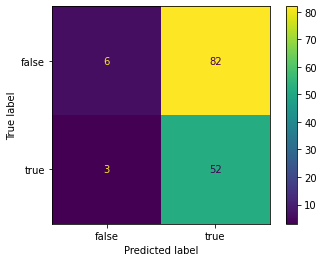

In [85]:
disp = ConfusionMatrixDisplay(confusion_matrix=cleaned_cm, display_labels=['false', 'true']) #usikker på rekkefølgen her
disp.plot()

#### option 2: Manually change triple label of conflicting 

### Dataset similarities to fb15k
Many entities from the fake news datasets have not been seen in the original FB15k knowledge graph. How does this affetc the performance of the classification?

In [25]:
#
print('no. unique entities in fake news dataset:', len(dataset_entities))
print('no. new entities in fake news dataset:', len(new_entities))


no. unique entities in fake news dataset: 155
no. new entities in fake news dataset: 108


We observe that only 30% of entities in the fake news dataset are in the original FB15k knowledge graph..

In [26]:
known_triples = []
known_labels = []
for i in range(len(triples)):
    triple = triples[i]
    if triple[0] not in new_entities and triple[2] not in new_entities:
        known_triples.append(tuple(triple))
        known_labels.append(labels[i])
print('no. triples with known entities:', len(known_triples))

known_triples = np.array(known_triples)
known_labels = torch.tensor(known_labels, dtype=torch.int64)

no. triples with known entities: 61


In [27]:
kt = np.vsplit(known_triples.T, 3)

known_heads = kt[0].flatten()
known_relations = kt[1].flatten()
known_tails = kt[2].flatten()


known_le_heads = le_entity.transform(known_heads)
known_le_tails = le_entity.transform(known_tails)
known_edge_index = torch.tensor([known_le_heads, known_le_tails], dtype=torch.long)

known_le_relations = le_relation.transform(known_relations)
known_edge_type = torch.tensor(known_le_relations, dtype=torch.long)

In [28]:
known_edge_index

tensor([[  137,  4792,   466,  4792,  4792,  4792,  4792, 10187,  4792,  4792,
         10782,  4792,  4792, 10190,  4792,  4792,  4792,  4792,   466,  4792,
          4792,  4792, 11775,  4792,  4792,  4792,  4792,  4792,  4792,  4792,
          6589,  4792,  4792,  4792,  4792,  4792,  4792,  4792, 11187,  4792,
          4792,  5627,  4792,  4792,  4792,  4792,  4792,  4792,  4792,  4792,
          4792,  4792,  4792,  4792, 10807,  7185, 10807, 11999,  4792,  4792,
          4792],
        [10338,  9034,  9034,  9034,  9034,  9034,   819, 10807,  9034,  9034,
          9034,  9034,  9034, 10807,  9034,  9034,  9034,  9034,  9034,  4583,
          9034,  9034, 11945,  9034,  9034,  9034,  9034,  9034,  9034,  6589,
          6817,  6589,  6589,  9034,  9034,  9034,  9034,  9034, 10807,  9034,
          9034, 11226,  9034, 11944,  9034,  9034,  9034,  9034,  9034,  9034,
          9034,  9034,  9034,  9034,  7185,  9034,  7185,  9034,  9034,  9034,
         10807]])

In [29]:
known_pred = model.lp_score(z, known_edge_index, known_edge_type)
known_pred_classes = torch.tensor([0 if p < 0 else 1 for p in known_pred], dtype=torch.int64)

precision_score(known_labels, known_pred_classes)

0.3673469387755102

How about performance on triples with only unseen entities:

In [30]:
unknown_triples = []
unknown_labels = []
for i in range(len(triples)):
    triple = triples[i]
    if triple[0] in new_entities and triple[2] in new_entities:
        unknown_triples.append(tuple(triple))
        unknown_labels.append(labels[i])
print('no. triples with known entities:', len(unknown_triples))

unknown_triples = np.array(unknown_triples)
unknown_labels = torch.tensor(unknown_labels, dtype=torch.int64)

no. triples with known entities: 76


In [31]:
ukt = np.vsplit(unknown_triples.T, 3)

unknown_heads = ukt[0].flatten()
unknown_relations = ukt[1].flatten()
unknown_tails = ukt[2].flatten()


unknown_le_heads = le_entity.transform(unknown_heads)
unknown_le_tails = le_entity.transform(unknown_tails)
unknown_edge_index = torch.tensor([unknown_le_heads, unknown_le_tails], dtype=torch.long)

unknown_le_relations = le_relation.transform(unknown_relations)
unknown_edge_type = torch.tensor(unknown_le_relations, dtype=torch.long)

In [32]:
unknown_pred = model.lp_score(z, unknown_edge_index, unknown_edge_type)
unknown_pred_classes = torch.tensor([0 if p < 0 else 1 for p in unknown_pred], dtype=torch.int64)

precision_score(unknown_labels, unknown_pred_classes)

0.42105263157894735

# Fake News Net
## Step 1: Import triple extracted dataset

In [237]:
#load test data
FNN = pd.read_csv(
        "./data/FakeNewsNet/train.csv",
        sep=",",
        header=0,
        engine="python",
        index_col=0
    )

FNN = FNN.set_index('text_id')

FNN.tail(5)

,head,relation,tail,fb_head,fb_tail,label
text_id,,,,,,
415,William H. Seward,organization/role/leaders./organization/leader...,Republican Party,/m/0k_2z,/m/085srz,True
415,John Tyler,people/person/employment_history./business/emp...,President of the United States,/m/042dk,/m/02mjmr,True
415,Donald Trump,people/person/employment_history./business/emp...,President of the United States,/m/0cqt90,/m/02mjmr,True
415,Hillary Clinton,people/person/employment_history./business/emp...,President of the United States,/m/0d06m5,/m/02mjmr,True
416,Donald Trump,people/person/employment_history./business/emp...,King,/m/0cqt90,/m/03w9bnr,True


In [238]:
heads = FNN["fb_head"]
tails = FNN["fb_tail"]
relations = FNN["relation"]

relations = ["/" + rel for rel in relations]

relations[0]

'/organization/role/leaders./organization/leadership/person'

In [239]:
#construct entity encoder with original and new entity ids
entity_id = pd.read_csv('data/FB15k/entities.txt', sep='\t', header=None, names=['entity', 'id'], engine='python')
model_entities = entity_id['entity'].values
print('no. unique entities (original):', len(model_entities))

# add unseen entities from fake news dataset
dataset_entities = np.concatenate([np.array(heads), np.array(tails)])
dataset_entities =  np.unique(dataset_entities)
print('no. unique entities in dataset:', len(dataset_entities))
new_entities = np.array([ent for ent in dataset_entities if not ent in model_entities])
print('no. unseen entities in dataset:', len(new_entities))

all_entities = np.concatenate((model_entities, new_entities), axis=0)
print('no. unique entities (updated):', len(all_entities))

print('/m/01fnkt' in new_entities)

no. unique entities (original): 14951
no. unique entities in dataset: 682
no. unseen entities in dataset: 542
no. unique entities (updated): 15493
True


In [240]:
# fit encoder
le_entity_fnn = LabelEncoder()
le_entity_fnn.classes_ = np.load(path.join('fn_embeddings','le_entity_classes.npy'), allow_pickle=True)
#load relation encoder
le_relation_fnn = LabelEncoder()
le_relation_fnn.classes_ = np.load(path.join('fn_embeddings','le_relation_classes.npy'), allow_pickle=True)

In [241]:
le_entity_fnn.transform(['/m/01fnkt'])

array([1577])

In [242]:
le_heads = le_entity_fnn.transform(heads)
le_tails = le_entity_fnn.transform(tails)
edge_index = torch.tensor([le_heads, le_tails], dtype=torch.long)

le_relations = le_relation_fnn.transform(relations)
edge_type = torch.tensor(le_relations, dtype=torch.long)

In [243]:
# create and 'encode' lables
raw_labels = np.array(FNN["label"])
false = 0
true = 0
for l in raw_labels:
    if l == False:
        false += 1
    else:
        true += 1
print('no. true:', true)
print('no. false:', false)
labels = torch.tensor([0 if l == False else 1 for l in raw_labels], dtype=torch.int64)

no. true: 589
no. false: 411


In [252]:
model = torch.load("output/FB15k_237_CPU_20epochs.pkl", map_location=torch.device('cpu'))

model.z.shape

torch.Size([16035, 256])

In [253]:
pred = model.lp_score(model.z, edge_index, edge_type)
pred_classes = torch.tensor([0 if p < 0 else 1 for p in pred], dtype=torch.int64)

cm = confusion_matrix(labels, pred_classes)

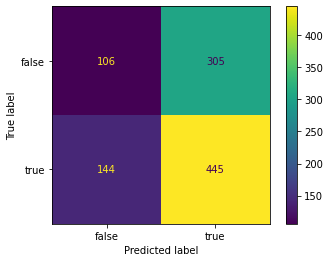

In [254]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['false', 'true']) #usikker på rekkefølgen her
disp.plot()

In [255]:
triple_classification_acc = precision_score(labels, pred_classes)

print('Triple validity prediction vs its documents label:', triple_classification_acc)

Triple validity prediction vs its documents label: 0.5933333333333334


## Document classification
The fist strategy will be to assign the lable 'False' to a document as long as one false triple was observed in it..

In [256]:
text_pred_dict = {}
for i in range(edge_index.shape[1]):
    text_id = FNN.index[i]
    pred_class = pred_classes[i]
    if text_id in text_pred_dict:
        if pred_class == 0:
            text_pred_dict[text_id] = pred_class
    else:
        text_pred_dict[text_id] = pred_class
        
pred_text_labels = np.array(list(text_pred_dict.values())).flatten()
pred_text_labels.shape

(280,)

In [257]:
text_labels = FNN.groupby('text_id').mean().values.flatten()

print('Percentage of true documents:', text_labels.mean())

Percentage of true documents: 0.5321428571428571


In [258]:
precision_score(text_labels, pred_text_labels)

0.5228758169934641

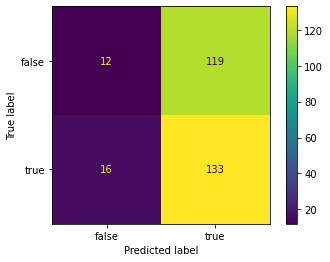

In [251]:
text_cm = confusion_matrix(text_labels, pred_text_labels)
text_disp = ConfusionMatrixDisplay(confusion_matrix=text_cm, display_labels=['false', 'true']) #usikker på rekkefølgen her
text_disp.plot()